# Boundary-value problems

As you probably know from Calculus, a boundary-value problem is a problem for an unknown $u= u(y)$ of the form 
$$\mathcal{L} u = f, \quad a < y < b,$$
where $\mathcal{L}$ is a differential operator defined on $[a,b]$ and $f = f(y)$ is a known function. For instance, consider the Poiseuille flow between two parallel plates driven by constant pressure gradient $P_l$. The problem that governs the velocity profile $u$ is
$$ \mu u_{yy} + P_l = 0, $$
subject to boundary conditions $u(a) = 0$ and $u(b) = 0$, where $b-a$ is the width of the chanel. It is clear in this case that $\displaystyle\mathcal{L} = \frac{\mathrm{d}^2}{\mathrm{d}y^2} $ and $f = -P_l/\mu$. The idea behind finding a numerical solution to the problem is, provided a discretization of operator $\mathcal{L}$ on a numerical grid $a \leq y_j \leq b$, to solve the algebraic system 
$$ (L u)_j = f_j, $$
where $L$ is an approximation to the operator $\mathcal{L}$ that includes the information from the boundary conditions and subindex $j$ indicates nodal values at $y_j$. If the problem is linear, the solution is found by simply inverting $y_j \simeq L^{-1} f_j$, given that $L$ is typically a square matrix. I will use linear examples first to get yourself familiarised with the different discretisation techniques. If the system is otherwise nonlinear, we can consider two approaches: i) apply a Newton-Raphson to the discretized system or viceversa, ii) use built-in solvers that does this process for us (although nothing prevents us from doing this for linear problems as well). More on this below.

## 1. Linear problems

### Finite differences for Poiseuille flow

In this section, we solve the boundary value problem for Poiseuille flow:

$$
0 = P_l + \mu \, u_{yy}, \quad 0 <  y< h,
$$

with the Dirichlet boundary conditions $u(0)=u(h)=0$.

The steps are as follows:

1. **Discretization:**  
   We discretize the domain $y \in [0,h]$ using a grid with spacing $\Delta y$.

2. **Finite Difference Approximation:**  
   The second derivative is approximated using the central difference scheme:
   $$
   u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2},
   $$
   which is valid for the interior nodes (i.e., those excluding the boundaries) and is second-order accurate. Boundary conditions need to be handled separately (see below).

4. **Matrix Formulation:**  
   With the finite difference approximation, the differential equation is rewritten in matrix form. Each interior row of the matrix represents the discretized version of the second derivative.

5. **Incorporating Boundary Conditions:**  
   The boundary conditions are imposed by replacing the rows corresponding to $y=0$ and $y=h$ with the conditions $u(0)=0$ and $u(h)=0$.

6. **Example Problem:**  
   For Poiseuille flow, the equation becomes
   $$
   \mu \, u_{yy} = -P_l,
   $$
   with the analytical solution given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python snippet below sets up the finite difference matrix, applies the boundary conditions via row replacement, and then solves the resulting linear system.


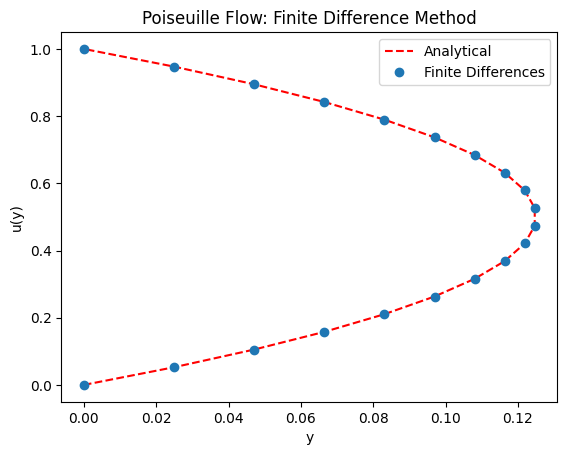

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 20          # Number of grid points
h_val = 1.0      # Domain [0, h]
mu = 1.0         # Viscosity coefficient
Pl = 1.0         # Pressure gradient

# Domain discretization
y = np.linspace(0, h_val, N)
dy = y[1] - y[0]

# Construct the finite difference matrix for u'' using central differences
A = np.zeros((N, N))
for i in range(1, N-1):
    A[i, i-1] = 1 / dy**2
    A[i, i]   = -2 / dy**2
    A[i, i+1] = 1 / dy**2

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0
A[0, :] = 0
A[0, 0] = 1.0
A[-1, :] = 0
A[-1, -1] = 1.0

# Set up the right-hand side vector.
# For interior nodes, the equation is: u'' = -Pl/mu.
b = np.full(N, -Pl/mu)
# Enforce boundary conditions in the right-hand side
b[0] = 0
b[-1] = 0

# Solve the linear system A u = b
u_numerical = np.linalg.solve(A, b)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Finite Differences')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Finite Difference Method')
plt.legend()
plt.show()


#### Structure of the Finite-Difference System (After Applying Boundary Conditions)

The discretized system for the Poiseuille flow problem is given by

$$
A\mathbf{u} = \mathbf{f},
$$

where the unknown vector is

$$
\mathbf{u} = \begin{pmatrix} u_0 \\ u_1 \\ \vdots \\ u_{N-1} \\ u_N \end{pmatrix}.
$$

The matrix $ A $ has the following structure after enforcing the Dirichlet boundary conditions:

$$
A = \begin{pmatrix}
1 & 0 & \cdots & 0 \\
\frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
0 & \cdots & \frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} \\
0 & \cdots & 0 & 0 & 1
\end{pmatrix}.
$$

The interior rows use the central difference approximation for the second derivative:

$$
u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2}, \quad i=1,2,\dots,N-1.
$$

Finally, the right-hand side vector $\mathbf{f}$ is initially defined for the interior nodes as

$$
f_i = -\frac{P_l}{\mu} \quad \text{for } i=1,2,\dots,N-1.
$$

To enforce the Dirichlet boundary conditions $ u_0 = 0$ and $ u_N = 0$, we must also **modify** (or "crush") the first and last elements of $ \mathbf{f} $ by setting:

$$
f_0 = 0 \quad \text{and} \quad f_N = 0.
$$

This ensures that both the system matrix $ A $ and the right-hand side vector $ \mathbf{f} $ correctly reflect the prescribed boundary conditions.


### Spectral Collocation using Chebyshev Polynomials for Poiseuille flow

In this section, we solve the same Poiseuille flow problem using spectral collocation with Chebyshev polynomials. The boundary value problem is

$$
0 = P_l + \mu \, u_{yy}, \quad u(0)=u(h)=0.
$$

The key ideas are:

1. **Chebyshev Collocation Points:**  
   We use Chebyshev–Gauss–Lobatto points, which are defined on the interval $[-1,1]$. They are given by
   $$
   x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0,\ldots, N,
   $$
   and then mapped to the domain $y\in [0, h]$ via
   $$
   y = \frac{(x+1)h}{2}.
   $$

2. **Differentiation Matrix:**  
   A Chebyshev differentiation matrix $D$ is computed, and then scaled to account for the transformation from $[-1,1]$ to $[0,h]$. The second derivative matrix is obtained as:
   $$
   D_2 = \left(\frac{2}{h}\right)^2 D^2.
   $$

3. **Imposing Boundary Conditions:**  
   The rows corresponding to the endpoints (i.e., the degrees of freedom at the boundaries) are replaced to enforce the Dirichlet conditions $u(0)=0$ and $u(h)=0$.

4. **Solving the System:**  
   With the modified differentiation matrix and right-hand side $f = -P_l/\mu$ (from $u_{yy} = -P_l/\mu$), we solve the system to obtain the numerical solution. The analytical solution is again given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python code below implements these steps.


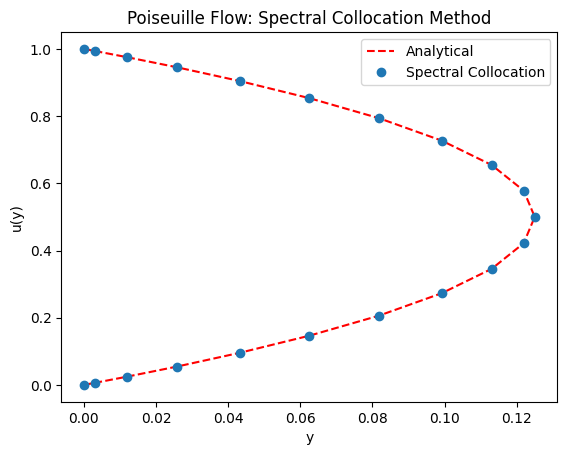

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cheb(N):
    """
    Compute the Chebyshev differentiation matrix and nodes.
    
    Returns:
        D (ndarray): Chebyshev differentiation matrix (size (N+1) x (N+1)).
        x (ndarray): Chebyshev nodes in [-1, 1].
    """
    if N == 0:
        return np.array([[0]]), np.array([1.0])
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * ((-1) ** np.arange(N + 1))
    X = np.tile(x, (N + 1, 1))
    dX = X - X.T
    D = (np.outer(c, 1/c)) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))
    return D, x

# Parameters for the problem
N = 20         # Degree of the Chebyshev polynomial (number of collocation points minus one)
h_val = 1.0    # Domain: [0, h]
mu = 1.0       # Viscosity coefficient
Pl = 1.0       # Pressure gradient

# Compute Chebyshev differentiation matrix and nodes
D, x_cheb = cheb(N)

# Transform Chebyshev nodes from [-1, 1] to [0, h]
y = (x_cheb + 1) * h_val / 2

# Scale the differentiation matrix for the transformation:
# Since y = (x+1)*h/2, we have dy/dx = h/2 so that d/dy = (2/h)*d/dx.
D = 2/h_val * D
D2 = np.dot(D, D)  # Second derivative matrix

# Right-hand side of the differential equation: u'' = -Pl/mu
f = -Pl/mu * np.ones(N + 1)

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0 by replacing the boundary rows.
D2[0, :] = 0
D2[0, 0] = 1.0
D2[-1, :] = 0
D2[-1, -1] = 1.0
f[0] = 0
f[-1] = 0

# Solve the system: mu * u'' = -Pl  ==>  u'' = -Pl/mu
u_numerical = np.linalg.solve(mu * D2, f)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Spectral Collocation')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Spectral Collocation Method')
plt.legend()
plt.show()


#### Comparison of Sparsity Patterns

When setting up the linear systems prior to solving, the two methods lead to very different matrix structures:

- **Finite Differences:**  
  The finite-difference method discretizes the second derivative using central differences. This produces a **sparse** matrix where nonzero elements are mostly confined to the main diagonal and the first sub- and super-diagonals (i.e., a tridiagonal pattern). The only exceptions occur in the rows modified to enforce Dirichlet boundary conditions.

- **Spectral Collocation (Chebyshev):**  
  In contrast, the spectral collocation method using Chebyshev polynomials results in a **dense** differentiation matrix. The global nature of Chebyshev polynomials causes nearly every element of the second derivative matrix to be nonzero—even after modifying the boundary rows to impose the Dirichlet conditions.

This difference means that finite-difference systems are usually cheaper to store and solve due to their sparsity, while spectral methods, although yielding dense matrices, can offer higher accuracy for smooth problems.


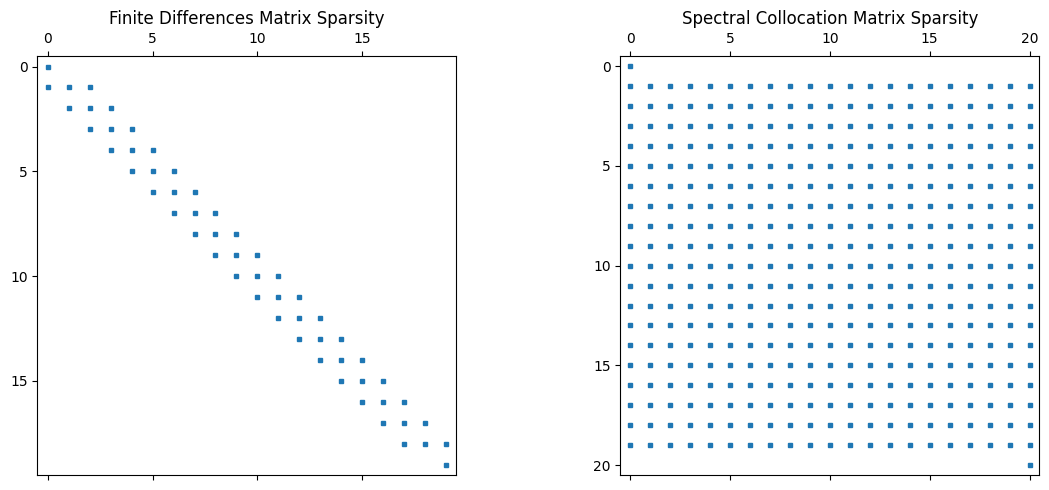

In [3]:
# Plot the sparsity patterns
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.spy(A, markersize=3)
plt.title('Finite Differences Matrix Sparsity')

plt.subplot(1,2,2)
plt.spy(D2, markersize=3)
plt.title('Spectral Collocation Matrix Sparsity')

plt.tight_layout()
plt.show()

Note how the first and last rows are modified so they effectively enforce the Dirichlet boundary conditions $u(0) = u(h) = 0$.

### Built-in BVP solver (SciPy)

We can solve the boundary value problem

$$
\mu u'' = -P_l,\quad u(0)=0,\quad u(h)=0,
$$

by converting it into a first-order system. Define

$$
u_1 = u,\quad u_2 = u',
$$

so that the system becomes

$$
u_1' = u_2,\quad u_2' = -\frac{P_l}{\mu}.
$$

The boundary conditions translate to

$$
u_1(0)=0,\quad u_1(h)=0.
$$


Using SciPy's `solve_bvp` function, we set up this system and its boundary conditions, provide an initial guess for the solution, and then solve for $u(y)$. The resulting solution is then plotted for visualization.

> SciPy’s `solve_bvp` function uses a collocation method with adaptive mesh refinement to solve two-point boundary value problems. More about SciPy's bvp solver on the [scipy.integrate.solve_bvp Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html)



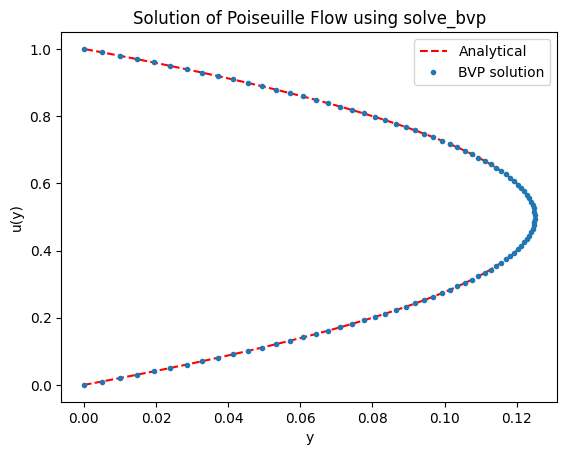

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Problem parameters
Pl = 1.0      # Pressure gradient
mu = 1.0      # Viscosity
h_val = 1.0   # Domain [0, h]

# Tolerance settings (adjust these to experiment with the solver's accuracy)
tol_value = 1e-6      # Solver tolerance; try different values (e.g., 1e-3, 1e-5)

# Define the system of first-order ODEs:
# u[0] = u, u[1] = u'
def fun(y, u):
    return np.vstack((u[1], -Pl/mu * np.ones_like(y)))

# Define the boundary conditions: u(0)=0 and u(h)=0
def bc(ua, ub):
    return np.array([ua[0], ub[0]])

# Create an initial mesh
y_mesh = np.linspace(0, h_val, 50)

# Provide an initial guess for u: both u and u' are initially zero
u_guess = np.zeros((2, y_mesh.size))

# Solve the boundary value problem with the specified tolerance and maximum nodes
sol = solve_bvp(fun, bc, y_mesh, u_guess, tol=tol_value)

# Evaluate the solution on a finer mesh
y_plot = np.linspace(0, h_val, 100)
u_plot = sol.sol(y_plot)[0]

#Analytical solution for visual comparison:
u_analytical = (-Pl / (2 * mu)) * y_plot**2 + (Pl / (2 * mu)) * h_val * y_plot

# Plot the solution
plt.figure()
plt.plot(u_analytical,y_plot, 'r--', label='Analytical')
plt.plot(u_plot, y_plot,'.', label=f'BVP solution')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Solution of Poiseuille Flow using solve_bvp')
plt.legend()
plt.show()


Observe how the built-in solver clusters nodes in regions where the gradient is steepest. While this bvp solver is both convenient and 
straightforward to implement, it can be seen as an overkill for solving such a simple problem.


### Another linear example: hydrodynamic journal bearings (infinitely-long limit)

We consider the dimensionless excess pressure $\Pi(\theta)$ in an infinitely long hydrodynamic journal bearing. The governing equation is

$$
\frac{d}{d\theta}\Bigl(\eta^3\,\frac{d\Pi}{d\theta}-\eta\Bigr)=0,\quad 0<\theta<2\pi,
$$

with the film profile $\eta=1-\epsilon\cos\theta$, and periodic boundary conditions $\Pi(0)=\Pi(2\pi)=0$.

Introducing 
$$
y_0=\Pi,\quad y_1=\frac{d\Pi}{d\theta},
$$
we obtain the first-order system

\begin{align}
& y_0'=y_1, \\
& y_1'=\frac{\eta'(\theta)}{\eta^3}\Bigl(1-3\eta^2\,y_1\Bigr),\quad\text{with}\quad \eta'(\theta)=\epsilon\sin\theta.
\end{align}

The analytical (Sommerfeld) solution is given by

$$
\Pi(\theta)=-\frac{\epsilon\,\sin\theta\,(2-\epsilon\cos\theta)}{(2+\epsilon^2)(1-\epsilon\cos\theta)^2}.
$$

Below is the Python implementation that solves this BVP and compares the numerical solution with the Sommerfeld solution for several values of $\epsilon$. 


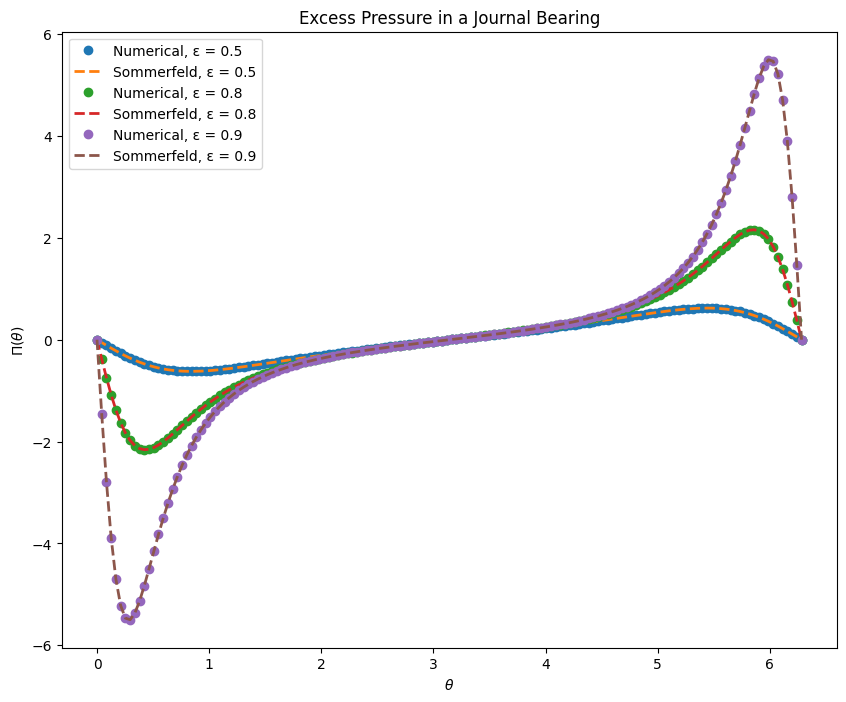

In [5]:
eps_values = [0.5, 0.8, 0.9]
theta_plot = np.linspace(0, 2*np.pi, 150)

plt.figure(figsize=(10, 8))
for eps in eps_values:
    # Define eta and its derivative for the current epsilon.
    def eta(theta):
        return 1 - eps * np.cos(theta)
    
    def eta_prime(theta):
        return eps * np.sin(theta)
    
    # ODE system: y[0] = Pi, y[1] = Pi'
    def fun(theta, y):
        dy0 = y[1]
        dy1 = (eta_prime(theta) / (eta(theta)**3)) * (1 - 3 * (eta(theta)**2) * y[1])
        return np.vstack((dy0, dy1))
    
    # Periodic boundary conditions: Pi(0)=Pi(2pi)=0
    def bc(ya, yb):
        return np.array([ya[0], yb[0]])
    
    theta_mesh = np.linspace(0, 2*np.pi, 200)
    y_guess = np.zeros((2, theta_mesh.size))
    
    sol = solve_bvp(fun, bc, theta_mesh, y_guess, tol=1e-4)
    if sol.status != 0:
        print(f"Warning: The BVP solver did not converge for eps = {eps}!")
    
    Pi_num = sol.sol(theta_plot)[0]
    Pi_sommerfeld = - (eps * np.sin(theta_plot) * (2 - eps*np.cos(theta_plot))) / ((2 + eps**2) * (1 - eps*np.cos(theta_plot))**2)
    
    plt.plot(theta_plot, Pi_num, 'o', lw=2, label=f'Numerical, ε = {eps}')
    plt.plot(theta_plot, Pi_sommerfeld, '--', lw=2, label=f'Sommerfeld, ε = {eps}')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\Pi(\theta)$')
plt.title('Excess Pressure in a Journal Bearing')
plt.legend()
# plt.grid(True)
plt.show()


Just for fun, let's plot the pressure distribution along a cylinder with arbitrary radius:

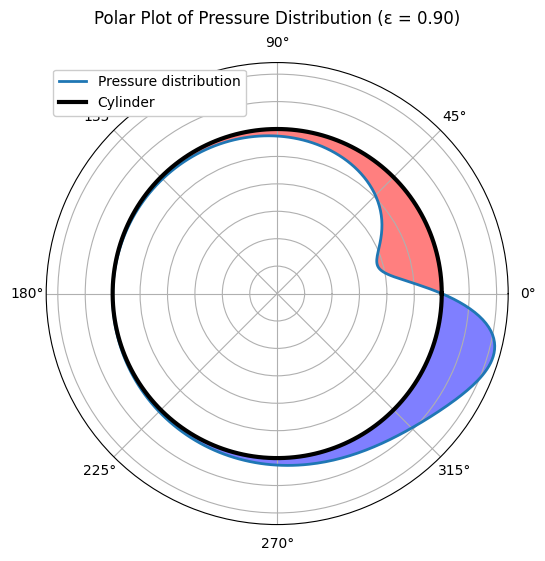

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Use the Sommerfeld solution for ε = 0.9
eps = 0.90
theta = np.linspace(0, 2*np.pi, 400)
Pi = - (eps * np.sin(theta) * (2 - eps*np.cos(theta))) / ((2 + eps**2) * (1 - eps*np.cos(theta))**2)

# Define an arbitrary base radius and a scaling factor to exaggerate the pressure variations
R0 = 6.0
scale = 0.4  # Adjust this factor as needed
r = R0 + scale * Pi

plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, lw=2, label='Pressure distribution')
ax.plot(theta, np.full_like(theta, R0), 'k-', lw=3, label='Cylinder')

# Fill the region above the cylinder (r >= R0) with red and below (r < R0) with blue.
ax.fill_between(theta, r, R0, where=(r >= R0), facecolor='blue', alpha=0.5)
ax.fill_between(theta, r, R0, where=(r < R0), facecolor='red', alpha=0.5)

ax.set_title(rf"Polar Plot of Pressure Distribution (ε = {eps:.2f})", va='bottom')
leg = ax.legend(loc='upper left')
leg.get_frame().set_alpha(1.0)
ax.set_yticklabels([])

plt.show()


## 2. Non-linear problems

### Blasius Boundary Layer with SciPy's `solve_bvp`

The Blasius boundary-layer equation is a classical nonlinear problem for a streamfunction $f = f(\eta)$ across a boundary layer with oncoming uniform velocity given by

$$
f''' + \frac{1}{2} f f'' = 0,
$$

with the boundary conditions

$$
f(0) = 0,\quad f'(0) = 0,\quad f'(\eta_\infty) = 1.
$$

To solve this using SciPy's built-in BVP solver, we first recast the third-order ODE into a system of first-order equations. Define

$$
y_1 = f,\quad y_2 = f',\quad y_3 = f'',
$$

so that the system becomes

$$
y_1' = y_2,\quad y_2' = y_3,\quad y_3' = -\frac{1}{2} y_1\, y_3.
$$

The boundary conditions are then expressed as

$$
y_1(0) = 0,\quad y_2(0) = 0,\quad y_2(\eta_\infty) = 1.
$$

In the code below, we choose a sufficiently large $\eta_\infty$ (e.g., 10) to approximate the condition at infinity and solve the problem using `solve_bvp`.


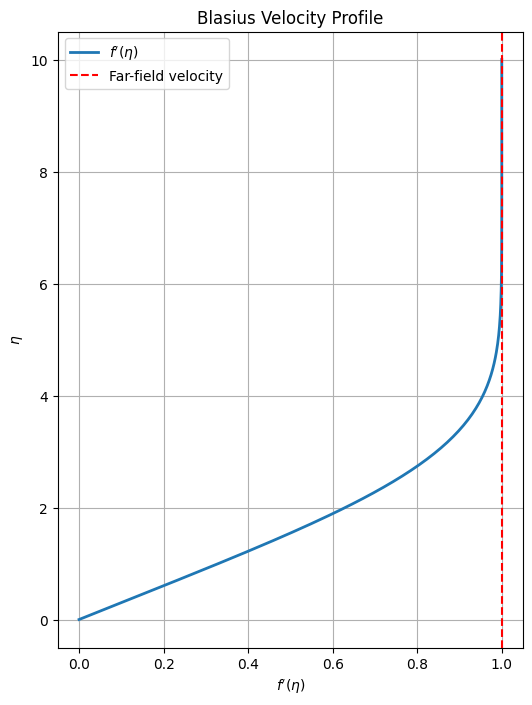

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Problem parameters
eta_max = 10.0       # A sufficiently large value to approximate infinity
tol_value = 1e-4     # Solver tolerance

# Define the system of ODEs.
# Let y[0] = f, y[1] = f', y[2] = f''.
def fun(eta, y):
    return np.vstack((y[1], y[2], -0.5 * y[0] * y[2]))

# Define the boundary conditions:
# At eta = 0: f(0)=0 and f'(0)=0.
# At eta = eta_max: f'(eta_max)=1.
def bc(ya, yb):
    return np.array([ya[0], ya[1], yb[1] - 1.0])

# Initial mesh for eta
eta_mesh = np.linspace(0, eta_max, 100)

# Initial guess for the solution.
# We provide an initial guess for f, f', and f''.
y_guess = np.zeros((3, eta_mesh.size))
y_guess[1] = np.linspace(0, 1, eta_mesh.size)  # Linear guess for f' from 0 to 1.

# Solve the BVP
sol = solve_bvp(fun, bc, eta_mesh, y_guess, tol=tol_value)

# Evaluate the solution on a finer mesh for plotting.
eta_plot = np.linspace(0, eta_max, 200)
f_plot   = sol.sol(eta_plot)[0]
fp_plot  = sol.sol(eta_plot)[1]


plt.figure(figsize=(6,8))
plt.plot(fp_plot, eta_plot, label="$f'(\\eta)$", lw = 2)
plt.axvline(1, color='red', linestyle='--', label="Far-field velocity")
plt.xlabel("$f'(\\eta)$")
plt.ylabel("$\\eta$")
plt.title("Blasius Velocity Profile")
plt.legend()
plt.grid(True)
plt.show()

### Frank–Kamenetskii Problem

The Frank–Kamenetskii problem in a spherical container is governed by
$$
\frac{1}{r^2}\frac{d}{dr}\Bigl(r^2\frac{du}{dr}\Bigr) + \delta\,e^{u} = 0,\quad 0<r<1,
$$
with the boundary conditions
$$
u'(0)=0,\quad u(1)=0.
$$
Here, $u(r)$ represents the dimensionless temperature increase and $\delta$ is the Frank–Kamenetskii parameter or Damkholer number. A steady solution exists only up to a critical parameter value $\delta_c$; as $\delta\to\delta_c$, the maximum temperature (typically at the center, $r\approx0$) diverges (indicating thermal runaway). The explosion curve, i.e. the plot of $u_{\text{max}}$ versus $\delta$, is obtained by computing the solution for increasing $\delta$ until convergence is lost.

Below is a Python implementation using SciPy’s `solve_bvp` that computes the explosion curve for increasing $\delta$ (in the range $0<\delta<\delta_c$).


Solver failed for δ = 3.4759


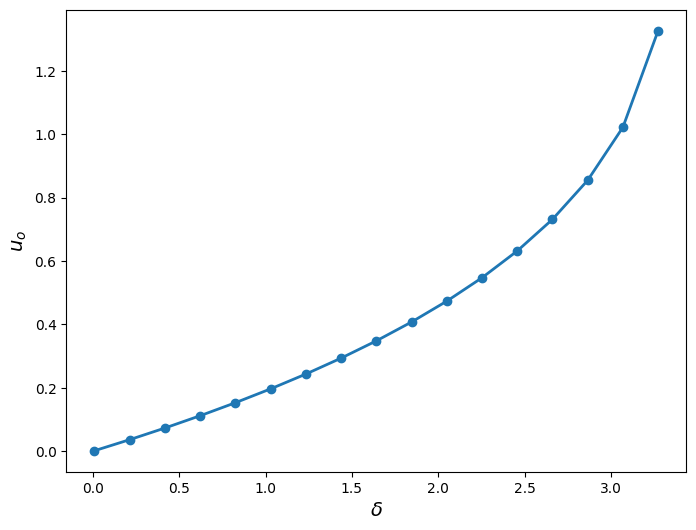

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Define the radial domain avoiding r = 0.
r0 = 1e-5
r_domain = np.linspace(r0, 1, 200)

# Frank–Kamenetskii ODE in spherical symmetry.
# Let y[0] = u and y[1] = u', with
#   u'' + (2/r) u' + δ exp(u) = 0.
def fk_fun(r, y, delta):
    safe_r = np.maximum(r, 1e-8)  # Avoid division by zero.
    dy0 = y[1]
    dy1 = -delta * np.exp(y[0]) - (2 * y[1] / safe_r)
    return np.vstack((dy0, dy1))

# Boundary conditions: u'(r0)=0 (regularity) and u(1)=0 (prescribed temperature).
def fk_bc(ya, yb):
    return np.array([ya[1], yb[0]])

# Define a range of δ-values to sweep; δ_c is approached as the solutions lose convergence.
delta_values = np.linspace(0.01, 10.0, 50)

u_center = []           # To store u(r0) for each successful solution
successful_deltas = []  # To store the corresponding δ values

for delta in delta_values:
    # Initial guess: zero temperature everywhere.
    y_guess = np.zeros((2, r_domain.size))
    sol = solve_bvp(lambda r, y: fk_fun(r, y, delta), fk_bc, r_domain, y_guess, tol=1e-4)
    if sol.status == 0:
        # For the spherical problem the maximum temperature is at the center.
        u_center.append(sol.sol(r_domain)[0][0])
        successful_deltas.append(delta)
    else:
        print(f"Solver failed for δ = {delta:.4f}")
        break

# Plot the explosion curve: maximum temperature (u_max) as a function of δ.
plt.figure(figsize=(8,6))
plt.plot(successful_deltas, u_center, 'o-', lw=2)
plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'$u_o$', fontsize=14)
# plt.title('Explosion Curve in the Frank–Kamenetskii Problem', fontsize=16)
# plt.grid(True)
plt.show()


Observe how difficult is to catch the critical Damkholer number. The explosion curve for the last successfully computed $\delta$ is nowhere near a vertical asymptote. We can change strategies by sweeping in centre values for temperature and letting the solver find the unique value of $\delta$ that satisfies all the conditions, i.e., $\delta$ is retrieved as an eigenvalue.  

In this approach the Frank–Kamenetskii problem

$$
\frac{1}{r^2}\frac{d}{dr}\Bigl(r^2\frac{du}{dr}\Bigr)+\delta e^{u}=0,\quad r_0<r<1,
$$

(with $ r_0\ll1 $) is solved by prescribing a value of $u(r_0)=u_0$ (the central temperature) and enforcing regularity,
$$
u'(r_0)=0,\quad u(1)=0.
$$

Then $\delta$ is treated as a **free parameter (an eigenvalue)** that **is obtained as part of the solution**. By sweeping over $u_0$ (say from 0 to 10) we obtain a curve of $u(0)$ versus $\delta$ – the so-called explosion curve for which only the first section, $0 < \delta < \delta_c$, is stable. Note how we recycle the solution as we loop over the $u_0$ values.

More information on this can be found [here](https://en.wikipedia.org/wiki/Frank-Kamenetskii_theory#Spherical_vessel).

Critical Damkholer number: 3.3216


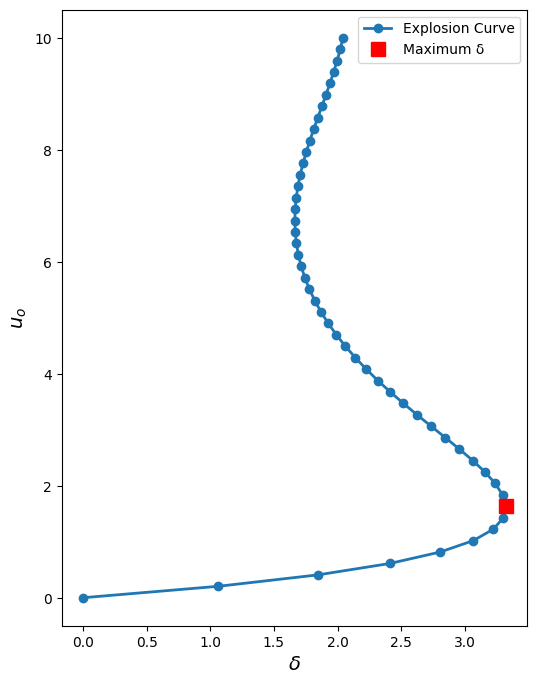

In [9]:
# Set a small r0 to avoid the singularity at r=0.
r0 = 1e-4
r_dom = np.linspace(r0, 1, 200)  # Radial domain (fixed)

# Define the BVP system.
# Let y[0] = u and y[1] = u', so that:
#   u'' + (2/r)*u' + δ exp(u) = 0,
# i.e.,
#   y0' = y1,
#   y1' = - (2/r)*y1 - δ exp(y0).
def fk_system(r, y, p):
    delta = p[0]  # Free parameter δ
    dy0 = y[1]
    dy1 = - (2.0/r)*y[1] - delta * np.exp(y[0])
    return np.vstack((dy0, dy1))

# Boundary conditions:
# At r=r0: u = u0 (swept parameter), u'(r0) = 0.
# At r=1: u = 0.
def bk_bc(ya, yb, p, u0):
    return np.array([ya[0] - u0,  # u(r0) = u0
                     ya[1],       # u'(r0) = 0
                     yb[0]])      # u(1) = 0

# Define the range of u0 (central temperature) values.
u0_values = np.linspace(0, 10, 50)
delta_values = []

# Initial guess for the solution: zero everywhere.
y_guess = np.zeros((2, r_dom.size))
# Initial guess for the free parameter δ.
p_guess = np.array([1.0])

# Loop over prescribed central temperatures.
for u0 in u0_values:
    # Modify the initial guess so that u(r0)=u0.
    y_guess[0, 0] = u0
    # Define the boundary condition function with the current u0.
    bc = lambda ya, yb, p: bk_bc(ya, yb, p, u0)
    # Solve the BVP with the current u0, recycling the previous solution.
    sol = solve_bvp(lambda r, y, p: fk_system(r, y, p), bc, r_dom, y_guess, p=p_guess, tol=1e-6)
    if sol.status == 0:
        delta_values.append(sol.p[0])
        # Re-interpolate the solution onto the fixed mesh for the next iteration.
        y_guess = sol.sol(r_dom)
        p_guess = sol.p
    else:
        print(f"Solver failed for u0 = {u0:.4f}")
        delta_values.append(np.nan)

# Plot the explosion curve: u0 (x-axis) vs. δ (y-axis).
plt.figure(figsize=(6,8))
plt.plot(delta_values, u0_values, 'o-', lw=2, label='Explosion Curve')

# Highlight the maximum δ obtained.
delta_array = np.array(delta_values)
max_idx = np.nanargmax(delta_array)
u0_max = u0_values[max_idx]
delta_max = delta_array[max_idx]
print("Critical Damkholer number: {:.4f}".format(delta_max))
plt.plot(delta_max, u0_max, 'rs', markersize=10, label='Maximum δ')

plt.xlabel(r'$\delta$', fontsize=14)
plt.ylabel(r'$u_o$', fontsize=14)
# plt.title('Explosion Curve in the Frank--Kamenetskii Problem', fontsize=16)
# plt.grid(True)
plt.legend()
plt.show()


### An advanced problem: equilibrium shape of a liquid film resting on a fibre under the action of molecular forces:

We consider the equilibrium of an annular liquid film deposited on a fibre of dimensionless radius $\eta$. The film thickness $h(x)$ (so that the radius is $r=\eta+h$) is governed by the *augmented* Young-Laplace equation
$$
P = \frac{1}{\bigl(\eta+h\bigr)\sqrt{1+h_x^2}} - \frac{h_{xx}}{\left(1+h_x^2\right)^{3/2}} + \Phi(h),
$$
where $\Phi(h) =  A\left(\frac{1}{h^3} - \frac{h_s^6}{h^9}\right)$ is a molecular potential that accounts for the molecular interactions between the liquid and the solid. The overall strength of the potential is $A$, and $h_s$ is the so-called *precursor*-film thickness, which is the thickness of the small patch of liquid that is left behind when the liquid *dewets* the solid substrate. The equation is integrated over the domain $0<x<L,$ with 
$$
L=\frac{\pi}{k_m},\quad k_m=\frac{1}{\sqrt{2}}\sqrt{3A+\frac{1}{(1+\eta)^2}}.
$$

The accompanying boundary conditions are symmetry-like conditions,
$$
h_x(0)=0,\quad h_x(L)=0,
$$
and the pressure eigenvalue $P$ is determined by mass (volume) conservation:
$$
\pi \int_0^L \Bigl(\eta+h(x)\Bigr)^2dx = \pi (1+\eta)^2L.
$$

In other words, the volume of the film is fixed to that of a uniform film of thickness $h=1$ (in dimensionless units). We expect the solution to feature a “bubble” region where the film bulges out for some $0<x<L^*$ and a precursor film of thickness $h_s$ for $L^*<x<L$.

To solve this eigenvalue BVP, we recast the second‐order ODE as a first‐order system by introducing
$$
y_0 = h,\quad y_1 = h_x,\quad y_2 = v,\quad \text{with} \quad v(x)=\int_0^x (\eta+h(s))^2 ds.
$$
Then the system becomes

$$
y_0' = y_1,
$$

$$
y_1' = \frac{1+h_1^2}{\eta+y_0} + \Phi(y_0)(1+y_1^2)^{3/2} - P(1+y_1^2)^{3/2},
$$

$$
y_2' = (\eta+y_0)^2.
$$

The boundary conditions are imposed as

- At $x=0$: $\,\, y_1(0)=0,\quad v(0)=0,$
- At $x=L$: $\,\, y_1(L)=0,\quad v(L) = (1+\eta)^2\,L.$

Below is a Python snippet that sets up and solves this BVP using SciPy’s `solve_bvp`, and then plots the radius $r(x)=\eta+h(x)$ versus $ x $.


BVP solver converged.
Computed value of P = 0.43195898963421187


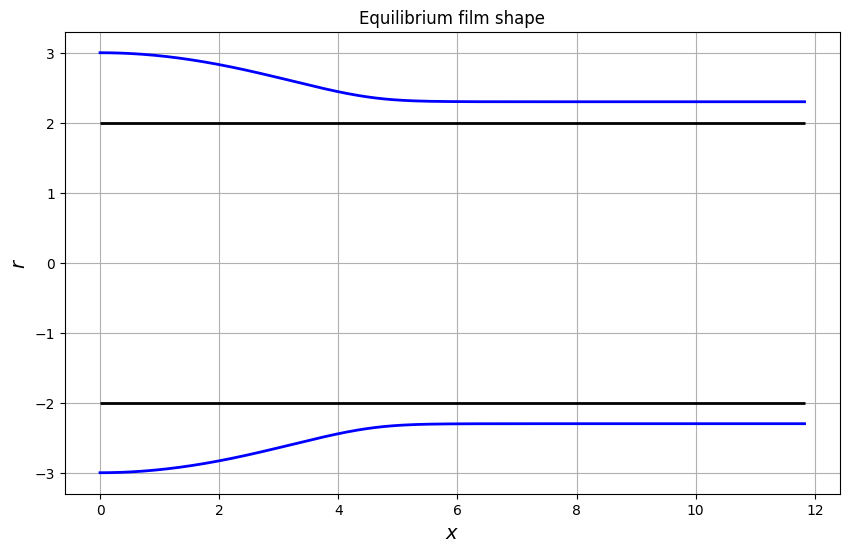

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Parameters
A   = 0.01
eta = 2.0
h_s = 0.3
h_max = 1.0   # chosen maximum film thickness at x=0

# Compute k_m and L:
k_m = 1/np.sqrt(2)*np.sqrt(3*A + 1/(1+eta)**2)
L = np.pi/k_m

# Define the BVP system.
# Let y[0] = h, y[1] = h_x, y[2] = v = ∫_0^x (eta+h)^2 dx.
def film_system(x, y, p):
    P = p[0]
    h = y[0]
    h_x = y[1]
    # ODE for h: h' = h_x
    dh_dx = h_x
    # ODE for h_x: obtained by rearranging
    #   P = 1/((eta+h)*sqrt(1+h_x^2)) - h_{xx}/(1+h_x^2)^(3/2) + A*(1/h^3 - h_s^6/h^9),
    # so that:
    dhxdx = (1 + h_x**2)**(1.5) * (1/(eta+h) + A*(1/h**3 - h_s**6/h**9) - P)
    # ODE for v: v' = (eta+h)^2.
    dv_dx = (eta + h)**2
    return np.vstack((dh_dx, dhxdx, dv_dx))

# Boundary conditions:
# At x=0: h(0)=h_max, h_x(0)=0.
# At x=L: h_x(L)=0, and v(L)=(eta+1)^2 L.
def film_bc(ya, yb, p):
    return np.array([
        ya[0] - h_max,          # h(0) = h_max
        ya[1],                  # h_x(0) = 0
        yb[1],                  # h_x(L) = 0
        yb[2] - (eta+1)**2 * L   # v(L) = (eta+1)^2 * L
    ])

# Set up the mesh.
x_mesh = np.linspace(0, L, 200)

# Initial guess for h(x): a function going from h_max at x=0 to the precursor h_s at x=L.
h_guess = h_s + (h_max - h_s) * np.cos(np.pi*x_mesh/(2*L))**2
# Its derivative:
h_x_guess = - (h_max - h_s) * (np.pi/L) * np.cos(np.pi*x_mesh/(2*L)) * np.sin(np.pi*x_mesh/(2*L))
# Guess for the volume accumulation v: linear from 0 to (eta+1)^2*L.
v_guess = np.linspace(0, (eta+1)**2 * L, x_mesh.size)
y_guess = np.vstack((h_guess, h_x_guess, v_guess))

# Initial guess for the eigenvalue P.
p_guess = np.array([0.0])

# Solve the BVP.
sol = solve_bvp(film_system, film_bc, x_mesh, y_guess, p=p_guess, tol=1e-4)

if sol.status != 0:
    print("BVP solver did not converge!")
else:
    print("BVP solver converged.")
    print("Computed value of P =", sol.p[0])

# Evaluate the solution on a fine mesh.
x_plot = np.linspace(0, L, 400)
h_sol = sol.sol(x_plot)[0]
r_sol = eta + h_sol   # radius r(x)= eta + h(x)

# Plot the equilibrium film shape: r(x) vs. x.
plt.figure(figsize=(10,6))
plt.plot(x_plot, r_sol, 'b-', lw=2)
plt.plot(x_plot,-r_sol, 'b-', lw=2)
# Plot the fibre:
plt.hlines( eta, 0, L, colors='k', lw=2)
plt.hlines(-eta, 0, L, colors='k', lw=2)

plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$r$', fontsize=14)
plt.title('Equilibrium film shape', fontsize=12)
plt.grid(True)
plt.show()


Observe how difficult it is to decrease the value of $h_s$. The solution above is originally converged for $h_s = 0.3$. The contact angle can be computed from this formula (Schwartz):
$$\cos \theta = 1 - 3 A/(8 h_s^2)$$
If one is interested in steeper contact angles (which strongly depend on the liquid-solid pair), we could try lower values of $h_s$. However, convergence is tricky, so we need to run a continuation approach for $h_s$. We start with a value of $h_s$ for which convergence is guaranteed and loop our way towards the desired $h_s$ by successively solving the problem. The initial guess for the subsequent iterations is taken from the previous one, which facilitates global convergence. This particular problem, being very nonlinear, needs many iterations to go for as low a value as $h_s = 0.08$:

Computed value of P = 0.9047407819589856


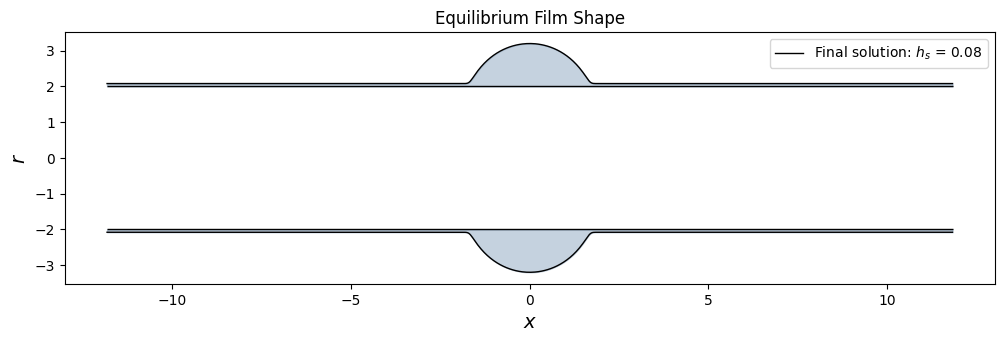

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Parameters
A = 0.01
eta = 2.0
h_s_initial = 0.5  # initial precursor thickness
h_s_final = 0.08    # final precursor thickness
h_max = 1.2        # film thickness at x=0

# Number of continuation steps.
num_steps = 300
hs_values = np.linspace(h_s_initial, h_s_final, num_steps)

# Compute k_m and L.
k_m = 1/np.sqrt(2) * np.sqrt(3*A + 1/(1+eta)**2)
L = np.pi / k_m

# Set up the spatial mesh.
x_mesh = np.linspace(0, L, 500)

# Global variable to hold the current precursor thickness for use in film_system.
hs_current = h_s_initial

# Define the BVP system.
# Let y[0] = h, y[1] = h_x, y[2] = v = ∫_0^x (\eta+h)^2 dx.
def film_system(x, y, p):
    P = p[0]
    h = y[0]
    h_x = y[1]
    # ODE for h: h' = h_x.
    dh_dx = h_x
    # ODE for h_x: rearranged from
    #   P = 1/((eta+h)*sqrt(1+h_x^2)) - h_{xx}/(1+h_x^2)^(3/2) + A*(1/h^3 - h_s^6/h^9)
    # so that:
    dhxdx = (1 + h_x**2)**(1.5) * (1/(eta + h) + A*(1/h**3 - hs_current**6/h**9) - P)
    # ODE for v: v' = (eta+h)^2.
    dv_dx = (eta + h)**2
    return np.vstack((dh_dx, dhxdx, dv_dx))

# Boundary conditions:
# At x=0: h(0)=h_max, h_x(0)=0.
# At x=L: h_x(L)=0, and v(L) = (eta+1)^2 * L.
def film_bc(ya, yb, p):
    return np.array([
        ya[0] - h_max,         # h(0) = h_max
        ya[1],                 # h_x(0) = 0
        yb[1],                 # h_x(L) = 0
        yb[2] - (eta+1)**2 * L   # v(L) = (eta+1)^2 * L
    ])

# Initial guess for h(x) using hs_initial:
hs_current = h_s_initial
h_guess = hs_current + (h_max - hs_current) * np.cos(np.pi*x_mesh/(2*L))**2
h_x_guess = - (h_max - hs_current) * (np.pi/L) * np.cos(np.pi*x_mesh/(2*L)) * np.sin(np.pi*x_mesh/(2*L))
v_guess = np.linspace(0, (eta+1)**2 * L, x_mesh.size)
y_guess = np.vstack((h_guess, h_x_guess, v_guess))

# Initial guess for the eigenvalue P.
p_guess = np.array([1.0/eta])

# Lists to store solutions.
solutions = []

# Sweep precursor thickness from h_s_initial to h_s_final.
for hs in hs_values:
    hs_current = hs  # update global precursor thickness for film_system
    sol = solve_bvp(film_system, film_bc, x_mesh, y_guess, p=p_guess, tol=1e-4)
    if sol.status == 0:
        solutions.append((hs, sol))
        # Re-interpolate the solution onto the fixed mesh for next iteration.
        y_guess = sol.sol(x_mesh)
        p_guess = sol.p.copy()
    else:
        print(f"Solver failed for h_s = {hs:.4f}")
        # Do not update guess.
        solutions.append((hs, None))

# Check that at least one solution exists.
if len(solutions) == 0 or solutions[-1][1] is None:
    print("No valid solution was obtained.")
else:
    # Use the final valid solution.
    hs_final_val, sol_final = solutions[-1]
    x_plot = np.linspace(0, L, 400)
    h_sol_final = sol_final.sol(x_plot)[0]
    r_sol_final = eta + h_sol_final  # r(x)=eta+h(x)
    
    # Mirror the solution for symmetric plotting, i.e. for -L<x<0.
    x_sym = np.concatenate((-x_plot[::-1], x_plot))
    r_sym = np.concatenate((r_sol_final[::-1], r_sol_final))
    
    plt.figure(figsize=(12,8))
    
    # If you want, plot intermediate solutions in light gray.
    # for hs_val, sol_obj in solutions[:-1]:
    #     if sol_obj is not None:
    #         h_temp = sol_obj.sol(x_plot)[0]
    #         r_temp = eta + h_temp
            # x_temp_sym = np.concatenate((-x_plot[::-1], x_plot))
            # r_temp_sym = np.concatenate((r_temp[::-1], r_temp))
            # plt.plot(x_plot, r_temp, color='gray', lw=1, alpha=0.15)

    # Pressure eigenvalue:
    print("Computed value of P =", sol.p[0]) 
    
    # Plot the final solution in a thick line.
    plt.plot(x_sym, r_sym, 'k', lw=1, label=f'Final solution: $h_s$ = {hs_final_val:.2f}')
    plt.plot(x_sym,-r_sym, 'k', lw=1)
    
    # Plot the fibre:
    plt.hlines(eta, -L, L, colors='k', lw=1)
    plt.hlines(-eta, -L, L, colors='k', lw=1)
    
    # Fill the space occupied by the film
    plt.fill_between(x_sym, 
                 np.full_like(x_sym, eta), 
                 r_sym, 
                 where=np.ones_like(x_sym, dtype=bool), 
                 color='#6F8FAF', alpha=0.4)
    plt.fill_between(x_sym, 
                 -r_sym, 
                 np.full_like(x_sym, -eta), 
                 where=np.ones_like(x_sym, dtype=bool), 
                 color='#6F8FAF', alpha=0.4)
    
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$r$', fontsize=14)
    plt.title('Equilibrium Film Shape', fontsize=12)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### Counterflow Diffusion Flame

> Taken from Prof. M. Matalon's lectures on Combsution Theory. [Youtube link](https://www.youtube.com/playlist?list=PLbInEHTmP9VawUQY7sUSY2FSGXYuXTb8g) for the lecture playlist. In particular, the diffusion flame lecture can be downloaded [here](https://cefrc.princeton.edu/sites/g/files/toruqf1071/files/Files/2013%20Lecture%20Notes/Matalon/Notes-Lecture-10.pdf).

Consider a one-step chemical reaction of the form 
$$\textrm{Fuel} + \nu \textrm{Oxidizer} \rightarrow \textrm{Products},$$
where $\nu$ is the mass ratio of oxidizer needed for complete combustion of one unit of fuel. Then, the fuel mass fraction $Y_F$, oxidizer mass fraction $Y_O$, and temperature $T$ of the mixture in a counterflow configuration is described by the following coupled equations:

$$
2x\frac{dY_F}{dx}+\frac{1}{Le_F}\frac{d^2Y_F}{dx^2}=\omega,
$$

$$
2x\frac{dY_O}{dx}+\frac{1}{Le_O}\frac{d^2Y_O}{dx^2}=\nu\,\omega,
$$

$$
2x\frac{dT}{dx}+\frac{d^2T}{dx^2}=-\omega,
$$

where $Le$ are Lewis numbers. The reaction rate is given by

$$
\omega = D\,Y_F\,Y_O\,\exp\Big[\beta\Big(\frac{1}{T_a}-\frac{1}{T}\Big)\Big],
$$
where $D$ is a *Damkholer number*, $\beta$ is the dimensionless activation energy, and $T_a = E/(R T_0)$ is a dimensionless activation temperature.

Boundary conditions (on a truncated domain $x\in[-x_{\text{max}},x_{\text{max}}]$, e.g. $x_{\text{max}}=10$) are:

- **Fuel side** ($x=-x_{\text{max}}$):
  $$
  Y_F = Y_{F,0},\quad Y_O = 0,\quad T = T_0,
  $$
- **Oxidizer side** ($x=x_{\text{max}}$):
  $$
  Y_F = 0,\quad Y_O = Y_{O,0},\quad T = T_0.
  $$

Numerical parameters (feel free to adjust):
$$
\beta=1,\quad \nu=7,\quad D=10,\quad T_0=1,\quad T_a=1,\quad Y_{F,0}=1,\quad Y_{O,0}=0.2.
$$

#### Numerical Strategy Outline

1. **Domain and Grid:**  
   Truncate the domain to $[-x_{\text{max}}, x_{\text{max}}]$ (e.g. $x_{\text{max}}=10$) and generate a spectral collocation grid using Chebyshev nodes to cluster points near $x=0$.

2. **System Formulation:**  
   Convert the second-order ODEs into a first-order system by defining:
   $$
   y_0 = Y_F,\quad y_1 = \frac{dY_F}{dx},\quad y_2 = Y_O,\quad y_3 = \frac{dY_O}{dx},\quad y_4 = T,\quad y_5 = \frac{dT}{dx}.
   $$

3. **Boundary Conditions & Solver:**  
   Apply the above boundary conditions at $x=-x_{\text{max}}$ and $x=x_{\text{max}}$, and use SciPy's `solve_bvp` to solve the resulting system.


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.15e-01       5.11e-26          64             77       
       2          7.02e-03       4.93e-39          141            12       
       3          6.09e-04       4.71e-37          153             0       
Solved in 3 iterations, number of nodes 153. 
Maximum relative residual: 6.09e-04 
Maximum boundary residual: 4.71e-37
Solver converged!


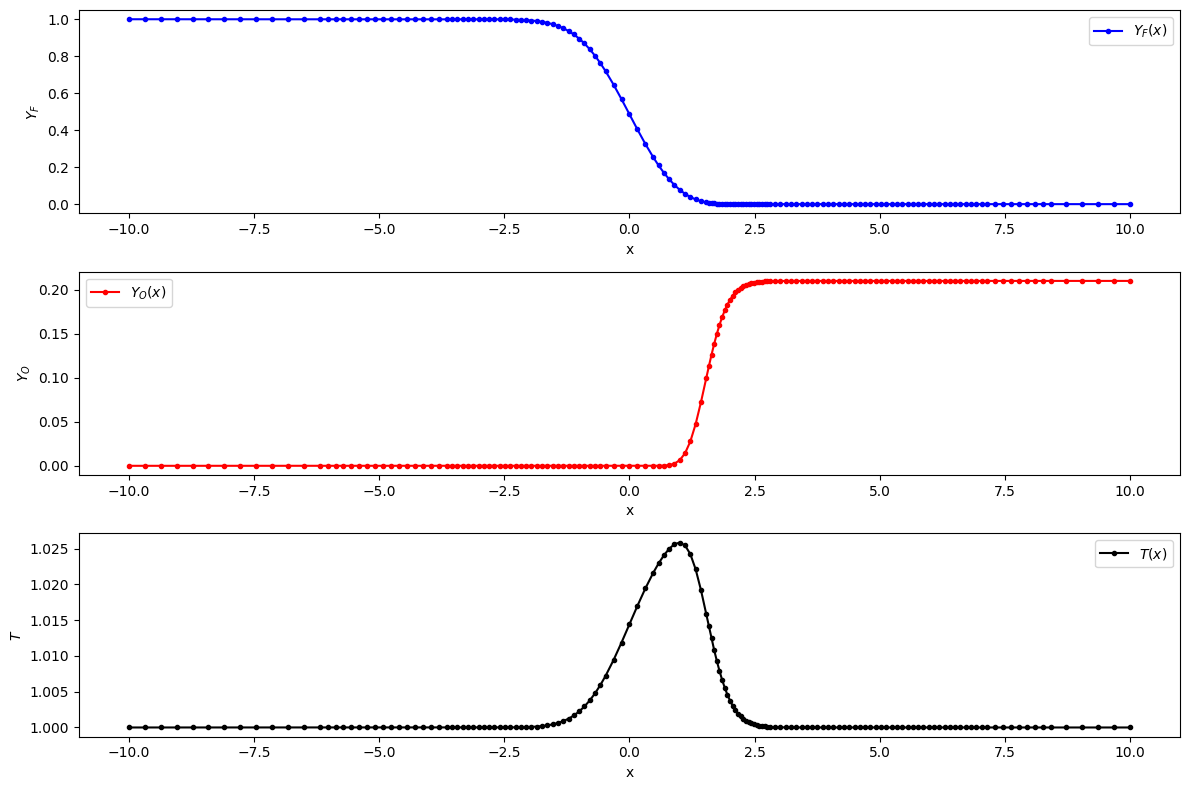

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.stats import norm

# -------------------------
# Problem Parameters
# -------------------------
beta    = 5
nu      = 7.1
D       = 100.0
T0      = 1.0
Ta      = 1.0
YF0     = 1.0   # Fuel mass fraction at x = -x_max (fuel side)
YO0     = 0.21  # Oxidizer mass fraction at x = x_max (oxidizer side)

# Lewis numbers for fuel and oxidizer:
Le_F    = 0.8    # Example: fuel Lewis number
Le_O    = 1.2    # Example: oxidizer Lewis number

# Domain definition:
x_max = 10.0
N = 128
x = np.linspace(-x_max,x_max,64)

# -------------------------
# Define the ODE system.
# We reduce the second-order equations to a first-order system by setting:
#
#   y0 = Y_F,  y1 = dY_F/dx,
#   y2 = Y_O,  y3 = dY_O/dx,
#   y4 = T,    y5 = dT/dx.
# -------------------------
def odes(x, y):
    # Unpack variables:
    YF   = y[0]
    dYF  = y[1]
    YO   = y[2]
    dYO  = y[3]
    T    = y[4]
    dT   = y[5]
    
    # Reaction rate:
    omega = D * YF * YO * np.exp(beta*(1/Ta - 1/T))
    
    # ODEs:
    # Fuel equation: 2x dY_F/dx + (1/Le_F) d^2Y_F/dx^2 = omega
    #   => d^2Y_F/dx^2 = Le_F*(omega - 2*x*dYF)
    d2YF = Le_F * (omega - 2 * x * dYF)
    
    # Oxidizer equation: 2x dY_O/dx + (1/Le_O) d^2Y_O/dx^2 = nu*omega
    #   => d^2Y_O/dx^2 = Le_O*(nu*omega - 2*x*dYO)
    d2YO = Le_O * (nu * omega - 2 * x * dYO)
    
    # Temperature equation: 2x dT/dx + d^2T/dx^2 = -omega
    #   => d^2T/dx^2 = -omega - 2*x*dT
    d2T = -omega - 2 * x * dT
    
    return np.vstack((dYF, d2YF, dYO, d2YO, dT, d2T))

# -------------------------
# Define boundary conditions.
# At x = -x_max (fuel side): Y_F = 1, Y_O = 0, T = 1.
# At x = x_max (oxidizer side): Y_F = 0, Y_O = 0.2, T = 1.
# -------------------------
def bc(ya, yb):
    return np.array([
        ya[0] - YF0,   # Y_F(-x_max) = 1
        ya[2] - 0.0,    # Y_O(-x_max) = 0
        ya[4] - T0,     # T(-x_max)  = 1
        yb[0] - 0.0,    # Y_F(x_max)  = 0
        yb[2] - YO0,    # Y_O(x_max)  = 0.2
        yb[4] - T0      # T(x_max)   = 1
    ])

# -------------------------
# Initial guess for the solution.
# We choose simple initial guesses: linear profiles for Y_F and Y_O and constant for T.
# -------------------------
y_guess = np.zeros((6, x.size))
y_guess[0] = np.linspace(YF0, 0.0, x.size)   # Y_F guess: from 1 to 0
y_guess[2] = np.linspace(0.0, YO0, x.size)     # Y_O guess: from 0 to 0.2
y_guess[4] = T0                               # T guess: constant = 1
# Estimate derivatives via finite differences:
y_guess[1] = np.gradient(y_guess[0], x)
y_guess[3] = np.gradient(y_guess[2], x)
y_guess[5] = np.gradient(y_guess[4], x)

# -------------------------
# Solve the BVP.
# -------------------------
sol = solve_bvp(odes, bc, x, y_guess, verbose=2)

if sol.status != 0:
    print("WARNING: The BVP solver did not converge!")
else:
    print("Solver converged!")

# -------------------------
# Plot the results using the solver's mesh.
# -------------------------
x_plot = sol.x  # Use the nodes from the solver
sol_y = sol.sol(x_plot)
YF_plot, YO_plot, T_plot = sol_y[0], sol_y[2], sol_y[4]

plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(x_plot, YF_plot, 'b.-', label=r'$Y_F(x)$')
plt.xlabel('x')
plt.ylabel(r'$Y_F$')
plt.legend()
# plt.grid(True)

plt.subplot(3,1,2)
plt.plot(x_plot, YO_plot, 'r.-', label=r'$Y_O(x)$')
plt.xlabel('x')
plt.ylabel(r'$Y_O$')
plt.legend()
# plt.grid(True)

plt.subplot(3,1,3)
plt.plot(x_plot, T_plot, 'k.-', label=r'$T(x)$')
plt.xlabel('x')
plt.ylabel(r'$T$')
plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()


For those of you wondering what we are actually looking at:

<img src="https://www.researchgate.net/publication/274641191/figure/fig1/AS:669436562378767@1536617522759/Schematic-view-of-a-counterflow-diffusion-flame-configuration.png" alt="Counterflow Diffusion Flame" width="600">


## Finite Element Method (FEM) Fundamentals and Galerkin Methods

This note provides an overview of the FEM based on Galerkin methods, details the derivation of the weak form, explains the element-wise formulation, and shows how stiffness and mass matrices are constructed. It also discusses the advantages of non-uniform grids.

### 1. Galerkin-Based Methods

- **Solution Approximation:**  
  The approximate solution is expressed as a linear combination of basis (trial) functions:
  $$ u_h(x) = \sum_{j=1}^{N} c_j\, \phi_j(x), $$
  where $\phi_j(x)$ are the chosen basis functions and $c_j$ are the unknown coefficients.

- **Test Functions and Weighted Residuals:**  
  In Galerkin methods, we require the residual (the error from substituting $u_h(x)$ in the strong form) to be orthogonal to each test function (often identical to the basis functions):
  $$ \int_\Omega \left( L(u_h) - f\right) \phi_i(x)\, dx = 0,\quad i = 1, 2, \ldots, N, $$
  where $L(u)$ is the differential operator and $f$ is the source term.

### 2. Weak Formulation and Boundary-Condition Implementation

- **Deriving the Weak Form:**  
  Consider the strong form:
  $$ -\epsilon\, u_{xx} + u = 1,\quad x\in (0,1), $$
  with Dirichlet boundary conditions $u(0)=0$ and $u(1)=1$. The steps are as follows:

  1. **Multiply by a Test Function:**  
     Multiply by a test function $v(x)$ and integrate over the domain:
     $$ \int_0^1 \left[-\epsilon\, u_{xx}+u\right] v(x)\, dx = \int_0^1 v(x)\, dx. $$

  2. **Integration by Parts:**  
     To reduce the differentiability requirement on $u$, integrate the $u_{xx}$ term by parts:
     $$ -\epsilon \int_0^1 u_{xx}\, v\, dx = \epsilon \int_0^1 u_x\, v_x\, dx - \epsilon \Big[ u_x \,v \Big]_0^1. $$
     With appropriate conditions (e.g., choosing $v(x)$ such that it vanishes at $x=0$ and $x=1$ or by enforcing the Dirichlet conditions directly), the boundary term is eliminated.

  3. **Final Weak Form:**  
     The resulting weak form is:
     $$ \epsilon \int_0^1 u_x\, v_x\, dx + \int_0^1 u\, v\, dx = \int_0^1 v\, dx, \quad \forall\, v\in V_0, $$
     where $V_0$ is the space of functions that vanish on the Dirichlet boundaries.

- **Boundary-Condition Implementation:**  
  In practice, the Dirichlet conditions are enforced strongly by prescribing the values at the boundary nodes (or by modifying the system after assembly).

### 3. Element-Wise Formulation and Matrix Assembly

#### Element-Wise Formulation

- **Domain Partitioning:**  
  The domain $[0,1]$ is partitioned into $n_{e}$ elements. For each element (e.g., between nodes $x_i$ and $x_{i+1}$), the solution is approximated locally using piecewise linear (hat) functions.

- **Local Basis Functions:**  
  On an element $e = [x_i, x_{i+1}]$, the local basis functions $\phi_i(x)$ and $\phi_{i+1}(x)$ satisfy:
  - $\phi_i(x_i)=1$, $\phi_i(x_{i+1})=0$,
  - $\phi_{i+1}(x_i)=0$, $\phi_{i+1}(x_{i+1})=1$.
  
- **Element Matrix and Load Vector:**  
  For each element, we compute:
  - **Stiffness Matrix ($K^{(e)}$):**  
    This matrix comes from the contribution of the derivative term in the weak form:
    $$ K^{(e)}_{ij} = \epsilon \int_{x_i}^{x_{i+1}} \phi_{i}^{\prime}(x)\, \phi_{j}^{\prime}(x)\, dx. $$
    For piecewise linear functions on an element of size $h_e = x_{i+1}-x_i$, the derivatives are constant:
    $$ K^{(e)} = \frac{\epsilon}{h_e} 
    \begin{pmatrix}
    1 & -1 \\
    -1 & 1 
    \end{pmatrix}. $$

  - **Mass Matrix ($M^{(e)}$):**  
    This matrix originates from the $u\,v$ term:
    $$ M^{(e)}_{ij} = \int_{x_i}^{x_{i+1}} \phi_i(x)\, \phi_j(x)\, dx. $$
    For linear elements, the mass matrix is given by:
    $$ M^{(e)} = \frac{h_e}{6}
    \begin{pmatrix}
    2 & 1 \\
    1 & 2 
    \end{pmatrix}. $$

  - **Combined Element Matrix:**  
    The local element matrix is the sum:
    $$ A^{(e)} = K^{(e)} + M^{(e)}. $$

  - **Local Load Vector:**  
    For a constant source term $f(x)=1$, the load vector is computed by:
    $$ f^{(e)}_i = \int_{x_i}^{x_{i+1}} \phi_i(x)\, dx. $$
    For linear elements, one obtains:
    $$ f^{(e)} = \begin{pmatrix} \frac{h_e}{2} \\ \frac{h_e}{2} \end{pmatrix}. $$

#### Global Assembly in Matrix Form

- **Matrix Equation:**  
  After computing the local contributions for each element, they are assembled into a global system of equations:
  $$ A\, \mathbf{c} = \mathbf{f}, $$
  where:
  - $\mathbf{c}$ is the vector of unknown coefficients for the trial functions.
  - $A$ is the global matrix constructed by summing the local element matrices, ensuring the proper overlap of basis functions.
  - $\mathbf{f}$ is the global load vector, assembled similarly.

- **Assembly Process:**  
  For each element, the local matrices and vectors contribute to the global system at the indices corresponding to the element’s nodes. For example, if an element spans nodes $i$ and $i+1$, then:
  $$ A[i:i+2,\, i:i+2] = A[i:i+2,\, i:i+2] + A^{(e)}, $$
  and similarly for the load vector:
  $$ \mathbf{f}[i:i+2] = \mathbf{f}[i:i+2] + f^{(e)}. $$
  
- **Imposing Dirichlet Conditions:**  
  The known boundary values (e.g., $u(0)=0$ and $u(1)=1$) are enforced by modifying the global system, often by eliminating or adjusting the corresponding equations.




Below is an implementation of the FEM to the model problem. Observe how a boundary-layer is formed at $x\simeq 0$ for sufficiently small values of $\epsilon$. Play around with this value and observe how many grid nodes you need to describe this region with decent accuracy.

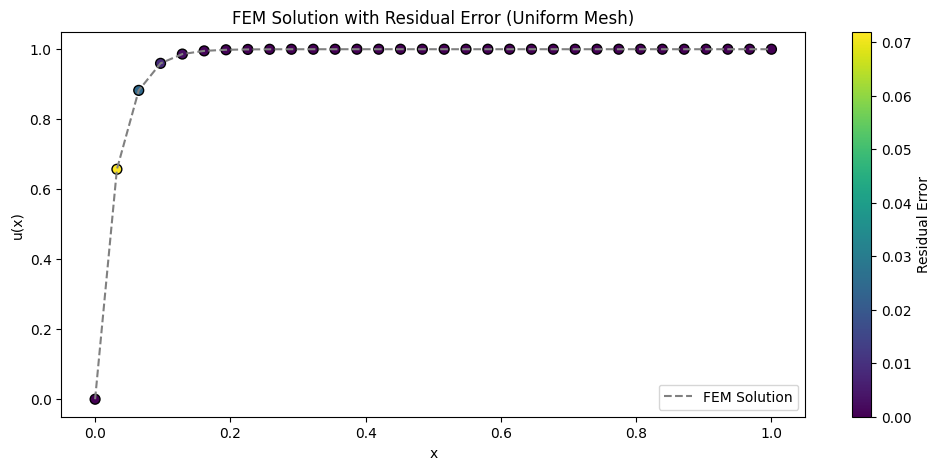

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.001
n_nodes = 32           # Number of nodes for uniform mesh
x = np.linspace(0, 1, n_nodes)  # Uniform mesh on [0,1]
h = x[1] - x[0]        # Constant element length

# Initialize global matrices and right-hand side vector
A = np.zeros((n_nodes, n_nodes))
f = np.zeros(n_nodes)

# Local element matrices (piecewise linear elements)
K_local = (epsilon / h) * np.array([[1, -1],
                                    [-1,  1]])
M_local = (h / 6) * np.array([[2, 1],
                              [1, 2]])
A_local = K_local + M_local
f_local = np.array([h/2, h/2])  # for right-hand side f(x)=1

# Assemble system
for elem in range(n_nodes - 1):
    nodes = [elem, elem+1]
    for i_local, i in enumerate(nodes):
        f[i] += f_local[i_local]
        for j_local, j in enumerate(nodes):
            A[i, j] += A_local[i_local, j_local]

# Apply Dirichlet boundary conditions: u(0)=0, u(1)=1.
u = np.zeros(n_nodes)
u[0] = 0.0
u[-1] = 1.0

A_interior = A[1:-1, 1:-1].copy()
f_interior = f[1:-1].copy()

# Adjust RHS for boundary contributions
f_interior -= A[1:-1, 0] * u[0]
f_interior -= A[1:-1, -1] * u[-1]

# Solve the interior system
u_interior = np.linalg.solve(A_interior, f_interior)
u[1:-1] = u_interior

# Compute residual-based error at interior nodes using central differences
error_uniform = np.zeros(n_nodes)
for i in range(1, n_nodes-1):
    u_xx = (u[i+1] - 2*u[i] + u[i-1]) / h**2
    error_uniform[i] = np.abs(-epsilon * u_xx + u[i] - 1)

# Plot the solution with error-based color markers for uniform mesh.
plt.figure(figsize=(12, 5))
sc1 = plt.scatter(x, u, c=error_uniform, cmap='viridis', s=50, edgecolor='k')
plt.colorbar(sc1, label='Residual Error')
plt.plot(x, u, linestyle='--', color='gray', label='FEM Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('FEM Solution with Residual Error (Uniform Mesh)')
plt.legend()
# plt.grid(True)
plt.show()


#### 4. Non-Uniform Grids

- **Motivation and Generation:**  
  In problems where the solution exhibits rapid changes (such as boundary layers when $\epsilon$ is small), a non-uniform grid can capture these details without an excessive number of total nodes.
  A common approach is to define a transformation from a uniform coordinate $t\in[0,1]$ to the physical coordinate $x$. For instance:
  $$ x(t) = \frac{\exp(\alpha\, t) - 1}{\exp(\alpha) - 1}, $$
  where $\alpha>0$ controls the clustering. Larger $\alpha$ clusters nodes near $x=0$ where the solution changes rapidly.

- **Advantages in FEM:**  
  - **Local Adaptivity:**  
    Since the element-wise formulation relies on the local element size $h_e$, changing $h_e$ per element is natural. This allows for high resolution in regions of interest.
  - **Efficiency:**  
    Concentrating nodes in regions with steep gradients (and using coarser resolution elsewhere) improves computational efficiency without sacrificing accuracy.
  - **Consistent Assembly:**  
    The process for assembling the global system remains the same irrespective of uniform or non-uniform grids. Only the computation of $h_e$ varies element to element.


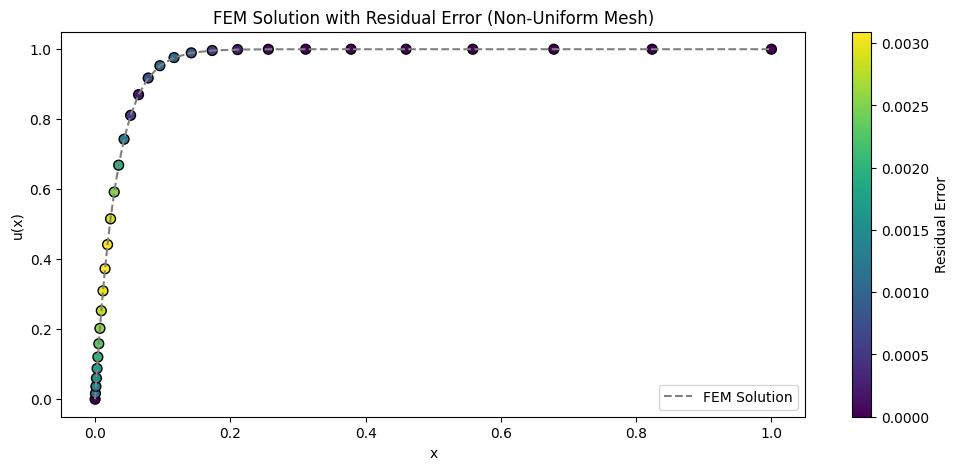

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for non-uniform (graded) mesh
epsilon = 0.001
n_nodes = 32   # Increase nodes for a better graded mesh
alpha = 6.0    # Grading parameter: larger alpha clusters nodes near x=0

# Generate a non-uniform mesh: from a uniform t-parameter via transformation.
t = np.linspace(0, 1, n_nodes)
x = (np.exp(alpha * t) - 1) / (np.exp(alpha) - 1)  # Clusters nodes near x=0
h_elems = np.diff(x)  # Element sizes

# Initialize global matrices and RHS vector
A = np.zeros((n_nodes, n_nodes))
f = np.zeros(n_nodes)

# Assemble the system element by element
for elem in range(n_nodes - 1):
    i = elem
    j = elem + 1
    h_e = h_elems[elem]  # Local element size
    
    # Local stiffness and mass matrices for element with non-uniform length
    K_local = (epsilon / h_e) * np.array([[1, -1],
                                          [-1, 1]])
    M_local = (h_e / 6) * np.array([[2, 1],
                                    [1, 2]])
    A_local = K_local + M_local
    f_local = np.array([h_e/2, h_e/2])
    
    A[i, i] += A_local[0, 0]
    A[i, j] += A_local[0, 1]
    A[j, i] += A_local[1, 0]
    A[j, j] += A_local[1, 1]
    
    f[i] += f_local[0]
    f[j] += f_local[1]

# Apply Dirichlet boundary conditions: u(0)=0, u(1)=1.
u = np.zeros(n_nodes)
u[0] = 0.0
u[-1] = 1.0

A_interior = A[1:-1, 1:-1].copy()
f_interior = f[1:-1].copy()
f_interior -= A[1:-1, 0] * u[0]
f_interior -= A[1:-1, -1] * u[-1]

u_interior = np.linalg.solve(A_interior, f_interior)
u[1:-1] = u_interior

# Compute residual-based error at interior nodes for non-uniform mesh
error_nonuniform = np.zeros(n_nodes)
for i in range(1, n_nodes-1):
    # For non-uniform mesh, let:
    a = x[i] - x[i-1]
    b = x[i+1] - x[i]
    # Use the non-uniform second derivative formula
    u_xx = (2/(a+b)) * ((u[i+1] - u[i]) / b - (u[i] - u[i-1]) / a)
    error_nonuniform[i] = np.abs(-epsilon * u_xx + u[i] - 1)

# Plot the solution with error-based color markers for non-uniform mesh.
plt.figure(figsize=(12, 5))
sc2 = plt.scatter(x, u, c=error_nonuniform, cmap='viridis', s=50, edgecolor='k')
plt.colorbar(sc2, label='Residual Error')
plt.plot(x, u, linestyle='--', color='gray', label='FEM Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('FEM Solution with Residual Error (Non-Uniform Mesh)')
plt.legend()
# plt.grid(True)
plt.show()


Have a look at the clustering mapping that we used:

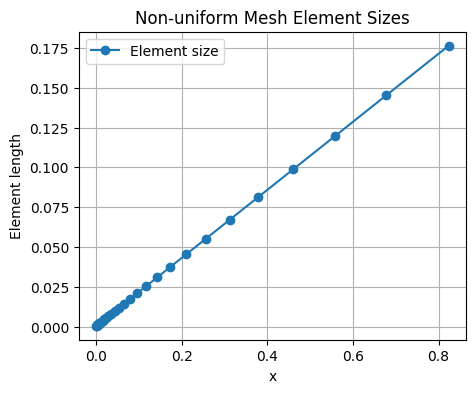

In [15]:
# Optionally, plot the non-uniform mesh spacing to see the clustering
plt.figure(figsize=(5, 4))
plt.plot(x[:-1], h_elems, 'o-', label='Element size')
plt.xlabel('x')
plt.ylabel('Element length')
plt.title('Non-uniform Mesh Element Sizes')
plt.legend()
plt.grid(True)
plt.show()

Note that in both plots of the solution, the markers are coloured accoring to the magnitude of an *error*. Also, note that for the numerical value of the parameters, the maximum error decreases by an order of magnitude for the non-uniform-grid case. But, how is this error defined and what can it be used for??? 

### Residual-Based Error Monitoring in FEM Solutions

When solving a differential equation using the finite element method (FEM), we often wish to gauge the quality of our numerical solution. One simple way is to evaluate the **residual-based error**. 

For an equation of the form
$$
-\epsilon\, u_{xx}(x) + u(x) = 1,
$$
the residual at a point $x_i$ is defined as
$$
R(x_i) = \Bigl| -\epsilon\, u_{xx}(x_i) + u(x_i) - 1 \Bigr|.
$$

This residual gives an indication of how well our computed solution $u_h(x)$ satisfies the differential equation at $x_i$. 

**How do we compute $u_{xx}(x_i)$?**
- **Uniform Mesh:** Use a standard central difference:
  $$
  u_{xx}(x_i) \approx \frac{u(x_{i+1}) - 2\, u(x_i) + u(x_{i-1})}{h^2},
  $$
  where $h$ is the constant element length.
- **Non-Uniform Mesh:** For nodes with spacing $a = x_i - x_{i-1}$ and $b = x_{i+1} - x_i$, use:
  $$
  u_{xx}(x_i) \approx \frac{2}{a+b}\left(\frac{u(x_{i+1}) - u(x_i)}{b} - \frac{u(x_i) - u(x_{i-1})}{a}\right).
  $$

By computing $R(x_i)$ for each interior node and plotting the solution with markers colored according to $R(x_i)$, we can visually compare the error distribution for uniform and non-uniform meshes. This enables us to see where the solution does not satisfy the equation as accurately, which is particularly useful when evaluating how mesh refinement (or grading) benefits the accuracy. This monitoring opens the door for adaptive refinement of the mesh.

Note that although FEM solves the problem variationally, we use finite differences to approximate $u_{xx}(x_i)$ because our FEM solution is only known at discrete nodes. This simple numerical differentiation provides a practical way to assess local error and guides potential adaptive meshing strategies.

## Higher-dimensions: the Poisson equation in 2D

We now consider the Poisson equation
$$
\Delta u = b,
$$
where $\Delta$ represents the 2D Laplacian operator, on the unit square
$$
(x,y) \in [0,1] \times [0,1],
$$
with Dirichlet boundary conditions that are not entirely homogeneous. In particular, we require that
- On the **top** ($y=1$), **left** ($x=0$), and **right** ($x=1$) boundaries, 
$$
u = 0,
$$
- On the **bottom** boundary ($y=0$), we impose a non–homogeneous condition:
$$
u(x,0) = u_o, \quad 0 < x < 1.
$$

#### Discretization and Finite Difference Approximation

We discretize the domain using a uniform grid with spacing
$$
h = \frac{1}{N-1},
$$
where $N$ is the number of grid points along each axis. At an interior grid point, the Laplacian is approximated by the five–point stencil:
$$
\frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4\, u_{i,j}}{h^2} = 1.
$$
Multiplying by $h^2$, this becomes
$$
u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4\, u_{i,j} = h^2.
$$

#### Row–Replacement for Enforcing Dirichlet Boundary Conditions

When assembling the linear system
$$
A\,\mathbf{u} = \mathbf{b},
$$
the standard approach for interior points is used to populate the corresponding rows with coefficients coming from the finite–difference approximation.

For boundary nodes where the solution is prescribed, we _replace_ the corresponding rows in $A$ (and adjust $\mathbf{b}$) to enforce the boundary condition exactly. This is done as follows:

- **Bottom Boundary ($y=0$):** For each point on the bottom boundary, we have the condition
  $$
  u(x,0) = u_o.
  $$
  Therefore, the corresponding row in the matrix is replaced by a row that has a 1 in the diagonal entry and zeros elsewhere. Simultaneously, the right–hand side entry is set to $u_o$.
  
- **Other Boundaries:** For $y=1$, $x=0$, and $x=1$, the homogeneous condition
  $$
  u = 0
  $$
  is enforced by replacing the corresponding rows with a unit diagonal and setting the corresponding entries in $\mathbf{b}$ to 0.

In this manner, the overall system faithfully represents both the finite–difference equations in the interior and the imposed boundary values via row–replacement.

The following Python cell illustrates the implementation of this procedure.


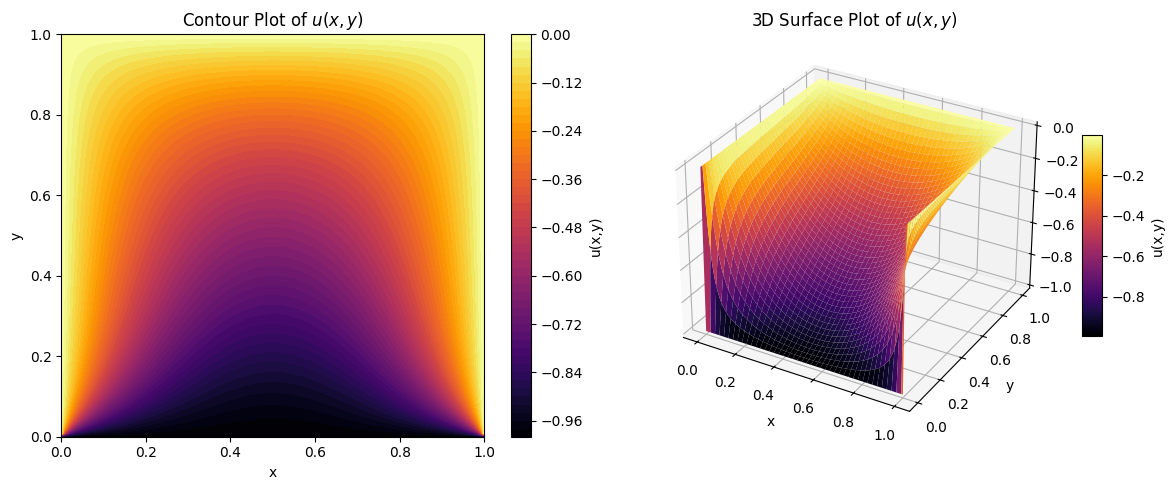

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D  # necessary for 3D plotting


# Set the number of grid points (including boundaries)
N = 128
h = 1.0 / (N - 1)
N2 = N * N   # total number of unknowns in a full N x N grid
b_val = -5.0 # Source term 
u_BC = -1.0  # Boundary value for u at the bottom

# Create a sparse matrix in LIL format for easy row modifications
A = lil_matrix((N2, N2))
b = np.zeros(N2)

# A helper function to convert 2D index (i,j) to 1D index
def idx(i, j):
    return j * N + i

# Loop over all grid points and set up the finite-difference equations
for j in range(N):
    for i in range(N):
        k = idx(i, j)
        # Identify boundary nodes:
        if j == 0:
            # Bottom boundary: u(x,0) = 1 (non-homogeneous)
            A[k, k] = 1.0
            b[k] = u_BC
        elif j == N - 1:
            # Top boundary: u = 0
            A[k, k] = 1.0
            b[k] = 0.0
        elif i == 0:
            # Left boundary: u = 0
            A[k, k] = 1.0
            b[k] = 0.0
        elif i == N - 1:
            # Right boundary: u = 0
            A[k, k] = 1.0
            b[k] = 0.0
        else:
            # Interior node: apply five–point stencil
            A[k, idx(i+1, j)] = 1.0 / h**2
            A[k, idx(i-1, j)] = 1.0 / h**2
            A[k, idx(i, j+1)] = 1.0 / h**2
            A[k, idx(i, j-1)] = 1.0 / h**2
            A[k, k] = -4.0 / h**2
            b[k] = -b_val

# Convert the sparse matrix to CSR format for efficient solving
A = A.tocsr()

# Solve the linear system
u_vec = spsolve(A, b)

# Reshape the solution back to a 2D grid
u = u_vec.reshape((N, N))

# Create grid for plotting
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 5))

# Contour plot:
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contourf(X, Y, u, 50, cmap='inferno')
fig.colorbar(contour, ax=ax1, label='u(x,y)')
ax1.set_title('Contour Plot of $u(x,y)$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 3D surface plot:
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X, Y, u, cmap='inferno', edgecolor='none')
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10, label='u(x,y)')
ax2.set_title('3D Surface Plot of $u(x,y)$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.tight_layout()
plt.show()

Observe how the boundary conditions are incompatible, i.e., the boundary values do not quite match at the corners $(0,0)$ and $(1,0)$. This produces steep gradients in the neighbourhood of these points that the FDM needs to smooth out. Inherently, this is achieved because of the concept of *numerical diffusion* that ensures that the numerically computed solutions remains nice and bounded even though the boundary conditions are not very friendly.